# Multiagent Debate 精度検証 (GSM8K)

論文 "Improving Factuality and Reasoning in Language Models through Multiagent Debate" (Du et al., 2023) の手法をローカルLLM (Ollama) で再現・検証する。

- **手法**: 複数のLLMエージェントが互いの回答を参照しながら議論（Debate）し、多数決で最終回答を決定
- **ベンチマーク**: GSM8K (Grade School Math 8K)
- **比較**: Single Agent (ベースライン) vs Multiagent Debate

In [1]:
# Cell 1: セットアップ & 依存関係

import json
import re
import time
from collections import Counter
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import ollama
from datasets import load_dataset
from tqdm.notebook import tqdm

# Ollama接続確認 & 利用可能モデル一覧
available_models = [m.model for m in ollama.list().models]
print("利用可能なモデル:", available_models)

# 使用モデル設定
MODEL = "qwen2.5:1.5b"  # デフォルト。available_modelsから選択可
assert MODEL in available_models, f"{MODEL} が見つかりません。ollama pull {MODEL} を実行してください。"
print(f"使用モデル: {MODEL}")

# 結果保存先
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


利用可能なモデル: ['qwen2.5:1.5b']
使用モデル: qwen2.5:1.5b


In [2]:
# Cell 2: GSM8Kデータセット読み込み

dataset = load_dataset("openai/gsm8k", "main", split="test")
print(f"GSM8K test set: {len(dataset)} 問")


def extract_gold_answer(answer_text: str) -> float | None:
    """GSM8Kの正解文字列から数値を抽出する。形式: '#### 数値'"""
    match = re.search(r"####\s*([\-\d,\.]+)", answer_text)
    if match:
        return float(match.group(1).replace(",", ""))
    return None


# サンプル数設定（動作確認用に少数から開始）
N_SAMPLES = 20
samples = dataset.select(range(N_SAMPLES))

# データ確認
print(f"\n使用サンプル数: {N_SAMPLES}")
print(f"\n--- サンプル問題 ---")
print(f"Q: {samples[0]['question']}")
print(f"A: {samples[0]['answer']}")
print(f"正解数値: {extract_gold_answer(samples[0]['answer'])}")

GSM8K test set: 1319 問

使用サンプル数: 20

--- サンプル問題 ---
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
A: Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
正解数値: 18.0


In [3]:
# Cell 3: コア関数の実装


def call_llm(messages: list[dict], model: str = MODEL) -> str:
    """Ollama APIでチャット補完を呼び出す。"""
    response = ollama.chat(model=model, messages=messages)
    return response.message.content


def construct_initial_prompt(question: str) -> list[dict]:
    """初期プロンプト生成（論文準拠）。"""
    return [
        {
            "role": "user",
            "content": (
                f"Can you solve the following math problem? {question}\n\n"
                "Explain your reasoning. Your final answer should be a single numerical number, "
                "in the form \\boxed{{answer}}, at the end of your response."
            ),
        }
    ]


def construct_debate_prompt(
    question: str, own_response: str, other_responses: list[str]
) -> list[dict]:
    """Debateラウンドのプロンプト生成。自分の前回回答 + 他エージェントの回答を参照させる。"""
    other_text = "\n\n".join(
        f"Agent {i+1}'s solution:\n{resp}" for i, resp in enumerate(other_responses)
    )
    return [
        {
            "role": "user",
            "content": (
                f"Can you solve the following math problem? {question}\n\n"
                "Explain your reasoning. Your final answer should be a single numerical number, "
                "in the form \\boxed{{answer}}, at the end of your response."
            ),
        },
        {"role": "assistant", "content": own_response},
        {
            "role": "user",
            "content": (
                f"These are the solutions to the problem from other agents:\n\n{other_text}\n\n"
                "Using the solutions from other agents as additional information, "
                "can you provide your answer to the math problem? "
                "Examine your solution and that of other agents. "
                "Put your final answer in the form \\boxed{{answer}}."
            ),
        },
    ]


def parse_answer(response: str) -> float | None:
    """LLM応答から数値回答を抽出する。\\boxed{N} 形式を優先し、なければ末尾の数値を取る。"""
    # \boxed{N} 形式
    boxed = re.findall(r"\\boxed\{([\-\d,\.\s]+)\}", response)
    if boxed:
        try:
            return float(boxed[-1].replace(",", "").strip())
        except ValueError:
            pass
    # フォールバック: 末尾の数値
    nums = re.findall(r"[\-]?[\d,]+\.?\d*", response)
    if nums:
        try:
            return float(nums[-1].replace(",", ""))
        except ValueError:
            pass
    return None


def most_frequent(answers: list[float | None]) -> float | None:
    """多数決で最終回答を決定する。Noneは除外。"""
    valid = [a for a in answers if a is not None]
    if not valid:
        return None
    counter = Counter(valid)
    return counter.most_common(1)[0][0]


# 動作確認
test_q = samples[0]["question"]
test_msgs = construct_initial_prompt(test_q)
print("プロンプト確認:")
print(test_msgs[0]["content"][:200], "...")
print("\nparse_answer テスト:")
print(f"  '\\boxed{{42}}' -> {parse_answer('The answer is \\boxed{42}')}")
print(f"  '答えは 123' -> {parse_answer('答えは 123')}")

プロンプト確認:
Can you solve the following math problem? Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder a ...

parse_answer テスト:
  '\boxed{42}' -> 42.0
  '答えは 123' -> 123.0


In [4]:
# Cell 4: ベースライン実験（Single Agent, No Debate）

print(f"=== ベースライン実験: Single Agent ({MODEL}) ===")
print(f"サンプル数: {N_SAMPLES}\n")

baseline_results = []

for i in tqdm(range(N_SAMPLES), desc="Baseline"):
    question = samples[i]["question"]
    gold = extract_gold_answer(samples[i]["answer"])

    messages = construct_initial_prompt(question)
    response = call_llm(messages)
    predicted = parse_answer(response)

    correct = predicted is not None and gold is not None and abs(predicted - gold) < 1e-6

    baseline_results.append(
        {
            "index": i,
            "question": question,
            "gold": gold,
            "predicted": predicted,
            "response": response,
            "correct": correct,
        }
    )

baseline_accuracy = sum(r["correct"] for r in baseline_results) / N_SAMPLES
print(f"\nベースライン精度: {baseline_accuracy:.1%} ({sum(r['correct'] for r in baseline_results)}/{N_SAMPLES})")

# 結果保存
with open(RESULTS_DIR / "baseline_results.json", "w") as f:
    json.dump({"model": MODEL, "n_samples": N_SAMPLES, "accuracy": baseline_accuracy, "results": baseline_results}, f, ensure_ascii=False, indent=2)

=== ベースライン実験: Single Agent (qwen2.5:1.5b) ===
サンプル数: 20



Baseline:   0%|          | 0/20 [00:00<?, ?it/s]


ベースライン精度: 45.0% (9/20)


In [5]:
# Cell 5: Multiagent Debate実験

N_AGENTS = 3
N_ROUNDS = 2  # 初期回答 + 1ラウンドのDebate = 論文の "2 rounds"

print(f"=== Multiagent Debate実験 ({MODEL}) ===")
print(f"エージェント数: {N_AGENTS}, ラウンド数: {N_ROUNDS}, サンプル数: {N_SAMPLES}\n")

debate_results = []

for i in tqdm(range(N_SAMPLES), desc="Debate"):
    question = samples[i]["question"]
    gold = extract_gold_answer(samples[i]["answer"])

    # Round 1: 各エージェントが独立に初期回答を生成
    agent_responses = []
    for agent_id in range(N_AGENTS):
        messages = construct_initial_prompt(question)
        response = call_llm(messages)
        agent_responses.append(response)

    rounds_history = [list(agent_responses)]  # Round 1の記録

    # Round 2+: Debateラウンド
    for round_num in range(1, N_ROUNDS):
        new_responses = []
        for agent_id in range(N_AGENTS):
            other_responses = [
                agent_responses[j] for j in range(N_AGENTS) if j != agent_id
            ]
            messages = construct_debate_prompt(
                question, agent_responses[agent_id], other_responses
            )
            response = call_llm(messages)
            new_responses.append(response)
        agent_responses = new_responses
        rounds_history.append(list(agent_responses))

    # 最終ラウンドの回答から多数決
    final_answers = [parse_answer(r) for r in agent_responses]
    predicted = most_frequent(final_answers)
    correct = predicted is not None and gold is not None and abs(predicted - gold) < 1e-6

    debate_results.append(
        {
            "index": i,
            "question": question,
            "gold": gold,
            "agent_final_answers": final_answers,
            "predicted": predicted,
            "correct": correct,
            "rounds_history": rounds_history,
        }
    )

debate_accuracy = sum(r["correct"] for r in debate_results) / N_SAMPLES
print(f"\nDebate精度: {debate_accuracy:.1%} ({sum(r['correct'] for r in debate_results)}/{N_SAMPLES})")
print(f"ベースライン精度: {baseline_accuracy:.1%}")
print(f"差分: {debate_accuracy - baseline_accuracy:+.1%}")

# 結果保存
with open(RESULTS_DIR / "debate_results.json", "w") as f:
    json.dump(
        {
            "model": MODEL,
            "n_agents": N_AGENTS,
            "n_rounds": N_ROUNDS,
            "n_samples": N_SAMPLES,
            "accuracy": debate_accuracy,
            "results": debate_results,
        },
        f,
        ensure_ascii=False,
        indent=2,
    )

=== Multiagent Debate実験 (qwen2.5:1.5b) ===
エージェント数: 3, ラウンド数: 2, サンプル数: 20



Debate:   0%|          | 0/20 [00:00<?, ?it/s]


Debate精度: 65.0% (13/20)
ベースライン精度: 45.0%
差分: +20.0%


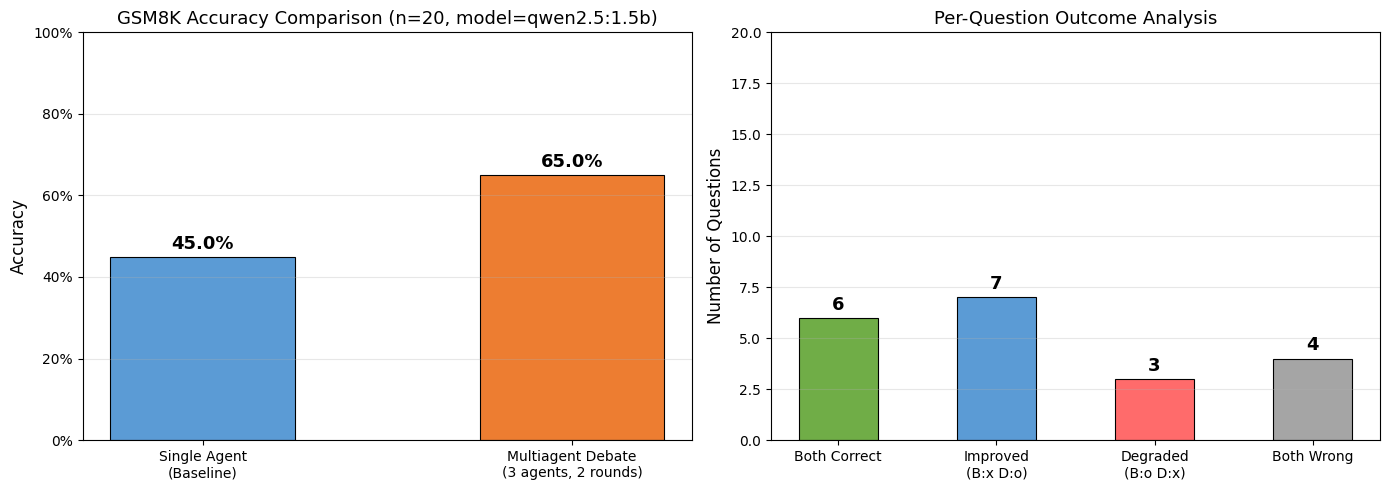

精度レポート
モデル: qwen2.5:1.5b
サンプル数: 20

Single Agent (Baseline): 45.0% (SE: 11.1%)
Multiagent Debate:       65.0% (SE: 10.7%)
差分:                    +20.0%

Debateで改善: 7 問
Debateで悪化: 3 問
両方正解:     6 問
両方不正解:   4 問


In [6]:
# Cell 6: 評価 & 可視化

# --- 精度比較 棒グラフ ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 棒グラフ: ベースライン vs Debate
methods = ["Single Agent\n(Baseline)", f"Multiagent Debate\n({N_AGENTS} agents, {N_ROUNDS} rounds)"]
accuracies = [baseline_accuracy, debate_accuracy]
colors = ["#5B9BD5", "#ED7D31"]

bars = axes[0].bar(methods, accuracies, color=colors, width=0.5, edgecolor="black", linewidth=0.8)
for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{acc:.1%}", ha="center", va="bottom", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].set_title(f"GSM8K Accuracy Comparison (n={N_SAMPLES}, model={MODEL})", fontsize=13)
axes[0].set_ylim(0, 1.0)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
axes[0].grid(axis="y", alpha=0.3)

# --- 問題ごとの正誤パターン分析 ---
improved = 0  # Debateで改善 (Baseline:× → Debate:○)
degraded = 0  # Debateで悪化 (Baseline:○ → Debate:×)
both_correct = 0
both_wrong = 0

for b, d in zip(baseline_results, debate_results):
    if not b["correct"] and d["correct"]:
        improved += 1
    elif b["correct"] and not d["correct"]:
        degraded += 1
    elif b["correct"] and d["correct"]:
        both_correct += 1
    else:
        both_wrong += 1

categories = ["Both Correct", "Improved\n(B:x D:o)", "Degraded\n(B:o D:x)", "Both Wrong"]
counts = [both_correct, improved, degraded, both_wrong]
cat_colors = ["#70AD47", "#5B9BD5", "#FF6B6B", "#A5A5A5"]

bars2 = axes[1].bar(categories, counts, color=cat_colors, width=0.5, edgecolor="black", linewidth=0.8)
for bar, cnt in zip(bars2, counts):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
                 str(cnt), ha="center", va="bottom", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Number of Questions", fontsize=12)
axes[1].set_title("Per-Question Outcome Analysis", fontsize=13)
axes[1].set_ylim(0, N_SAMPLES)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 精度レポート ---
# 標準誤差: SE = sqrt(p(1-p)/n)
baseline_se = np.sqrt(baseline_accuracy * (1 - baseline_accuracy) / N_SAMPLES)
debate_se = np.sqrt(debate_accuracy * (1 - debate_accuracy) / N_SAMPLES)

print("=" * 50)
print("精度レポート")
print("=" * 50)
print(f"モデル: {MODEL}")
print(f"サンプル数: {N_SAMPLES}")
print(f"")
print(f"Single Agent (Baseline): {baseline_accuracy:.1%} (SE: {baseline_se:.1%})")
print(f"Multiagent Debate:       {debate_accuracy:.1%} (SE: {debate_se:.1%})")
print(f"差分:                    {debate_accuracy - baseline_accuracy:+.1%}")
print(f"")
print(f"Debateで改善: {improved} 問")
print(f"Debateで悪化: {degraded} 問")
print(f"両方正解:     {both_correct} 問")
print(f"両方不正解:   {both_wrong} 問")


--- エージェント数: 1, ラウンド数: 2 ---


Agents=1:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 55.0%

--- エージェント数: 2, ラウンド数: 2 ---


Agents=2:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 45.0%

--- エージェント数: 3, ラウンド数: 2 ---


Agents=3:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 50.0%

--- エージェント数: 5, ラウンド数: 2 ---


Agents=5:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 60.0%

--- エージェント数: 3, ラウンド数: 1 ---


Rounds=1:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 55.0%

--- エージェント数: 3, ラウンド数: 2 ---


Rounds=2:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 30.0%

--- エージェント数: 3, ラウンド数: 3 ---


Rounds=3:   0%|          | 0/20 [00:00<?, ?it/s]

精度: 45.0%


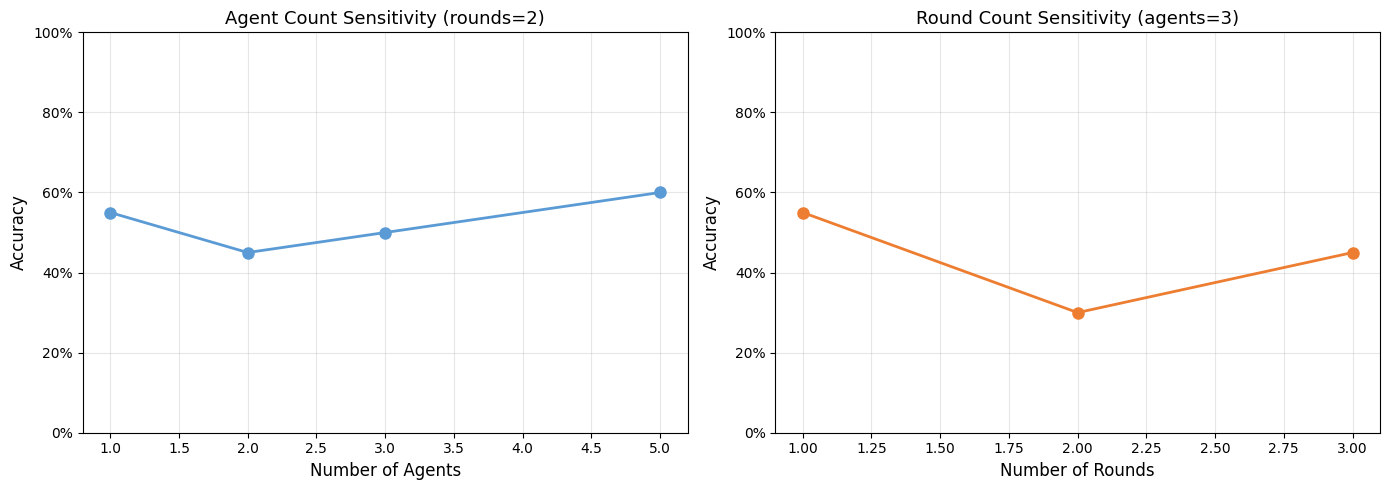


=== 感度分析結果 ===
エージェント数別精度: {1: '55.0%', 2: '45.0%', 3: '50.0%', 5: '60.0%'}
ラウンド数別精度: {1: '55.0%', 2: '30.0%', 3: '45.0%'}


In [8]:
# Cell 7:（オプション）パラメータ感度分析
# エージェント数・ラウンド数を変えて精度変化を測定する
# 実行時間が長いため、必要に応じて実行

RUN_SENSITIVITY = True  # Trueに変更して実行

if RUN_SENSITIVITY:
    # --- エージェント数の感度分析 ---
    agent_counts = [1, 2, 3, 5]
    fixed_rounds = 2
    agent_sensitivity = {}

    for n_agents in agent_counts:
        print(f"\n--- エージェント数: {n_agents}, ラウンド数: {fixed_rounds} ---")
        correct_count = 0

        for i in tqdm(range(N_SAMPLES), desc=f"Agents={n_agents}"):
            question = samples[i]["question"]
            gold = extract_gold_answer(samples[i]["answer"])

            agent_responses = []
            for _ in range(n_agents):
                messages = construct_initial_prompt(question)
                agent_responses.append(call_llm(messages))

            for round_num in range(1, fixed_rounds):
                new_responses = []
                for agent_id in range(n_agents):
                    if n_agents == 1:
                        # 1エージェントの場合はDebateなし（自分自身を再参照）
                        new_responses.append(agent_responses[agent_id])
                    else:
                        other = [agent_responses[j] for j in range(n_agents) if j != agent_id]
                        messages = construct_debate_prompt(question, agent_responses[agent_id], other)
                        new_responses.append(call_llm(messages))
                agent_responses = new_responses

            final_answers = [parse_answer(r) for r in agent_responses]
            predicted = most_frequent(final_answers)
            if predicted is not None and gold is not None and abs(predicted - gold) < 1e-6:
                correct_count += 1

        acc = correct_count / N_SAMPLES
        agent_sensitivity[n_agents] = acc
        print(f"精度: {acc:.1%}")

    # --- ラウンド数の感度分析 ---
    round_counts = [1, 2, 3]
    fixed_agents = 3
    round_sensitivity = {}

    for n_rounds in round_counts:
        print(f"\n--- エージェント数: {fixed_agents}, ラウンド数: {n_rounds} ---")
        correct_count = 0

        for i in tqdm(range(N_SAMPLES), desc=f"Rounds={n_rounds}"):
            question = samples[i]["question"]
            gold = extract_gold_answer(samples[i]["answer"])

            agent_responses = []
            for _ in range(fixed_agents):
                messages = construct_initial_prompt(question)
                agent_responses.append(call_llm(messages))

            for round_num in range(1, n_rounds):
                new_responses = []
                for agent_id in range(fixed_agents):
                    other = [agent_responses[j] for j in range(fixed_agents) if j != agent_id]
                    messages = construct_debate_prompt(question, agent_responses[agent_id], other)
                    new_responses.append(call_llm(messages))
                agent_responses = new_responses

            final_answers = [parse_answer(r) for r in agent_responses]
            predicted = most_frequent(final_answers)
            if predicted is not None and gold is not None and abs(predicted - gold) < 1e-6:
                correct_count += 1

        acc = correct_count / N_SAMPLES
        round_sensitivity[n_rounds] = acc
        print(f"精度: {acc:.1%}")

    # --- 可視化 ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(list(agent_sensitivity.keys()), list(agent_sensitivity.values()),
                 "o-", color="#5B9BD5", linewidth=2, markersize=8)
    axes[0].set_xlabel("Number of Agents", fontsize=12)
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].set_title(f"Agent Count Sensitivity (rounds={fixed_rounds})", fontsize=13)
    axes[0].set_ylim(0, 1.0)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    axes[0].grid(alpha=0.3)

    axes[1].plot(list(round_sensitivity.keys()), list(round_sensitivity.values()),
                 "o-", color="#ED7D31", linewidth=2, markersize=8)
    axes[1].set_xlabel("Number of Rounds", fontsize=12)
    axes[1].set_ylabel("Accuracy", fontsize=12)
    axes[1].set_title(f"Round Count Sensitivity (agents={fixed_agents})", fontsize=13)
    axes[1].set_ylim(0, 1.0)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "sensitivity_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

    # 結果保存
    with open(RESULTS_DIR / "sensitivity_results.json", "w") as f:
        json.dump(
            {
                "model": MODEL,
                "agent_sensitivity": {str(k): v for k, v in agent_sensitivity.items()},
                "round_sensitivity": {str(k): v for k, v in round_sensitivity.items()},
            },
            f,
            indent=2,
        )

    print("\n=== 感度分析結果 ===")
    print("エージェント数別精度:", {k: f"{v:.1%}" for k, v in agent_sensitivity.items()})
    print("ラウンド数別精度:", {k: f"{v:.1%}" for k, v in round_sensitivity.items()})
else:
    print("感度分析はスキップ。RUN_SENSITIVITY = True に変更して実行してください。")